In [2]:
import pandas as pd

df = pd.read_csv('./data/train.csv')
val_df = pd.read_csv('./data/val.csv')
test_df = pd.read_csv('./data/test.csv')

In [3]:
val_df.drop('ID',axis=1,inplace=True)

In [4]:
val_normal, val_fraud = val_df['Class'].value_counts()
val_contamination = val_fraud / val_normal
val_contamination

0.0010551491277433877

# train

## multivariate_normal

In [4]:
from scipy.stats import multivariate_normal
import numpy as np

p = multivariate_normal(mean=np.mean(val_df.drop('Class',axis=1),axis=0), cov=np.cov(val_df.drop('Class',axis=1).T))

x = p.pdf(df.drop('ID',axis=1))
print("max prob of x on X_train", max(x))
print("mean prob of x on X_train", np.mean(x))
print('-' * 60)
MyTrain = np.mean(x)

x = p.pdf(test_df.drop('ID',axis=1))
print("max prob of x on X_test", max(x))
print("mean prob of x on X_test", np.mean(x))
print('-' * 60)
MyTest = np.mean(x)

x = p.pdf(val_df[val_df['Class']==1].drop('Class',axis=1))
print("max prob of x on fraud_pca_data", max(x))
print("mean prob of x on fraud_pca_data", np.mean(x))
print('-' * 60)

print('Difference between mean prob of Train vs Test ', MyTrain - MyTest)

max prob of x on X_train 1.3751422423903634e-11
mean prob of x on X_train 3.628782228283286e-13
------------------------------------------------------------
max prob of x on X_test 1.1882034144303131e-11
mean prob of x on X_test 3.601238523353681e-13
------------------------------------------------------------
max prob of x on fraud_pca_data 4.1337547645646335e-14
mean prob of x on fraud_pca_data 2.0601008323016835e-15
------------------------------------------------------------
Difference between mean prob of Train vs Test  2.754370492960489e-15


In [5]:
from sklearn.metrics import f1_score

x = p.pdf(val_df.drop('Class',axis=1))

EpsF1 = []

epsilons = [1e-10, 1e-20, 1e-30, 1e-40, 1e-50, 1e-60, 1e-70, 1e-80, 1e-90, 1e-100, 1e-110, 1e-120,
           1e-130, 1e-140, 1e-150, 1e-160, 1e-170, 1e-180, 1e-190, 1e-200]

for e in range(len(epsilons)):
    eps = epsilons[e]
    pred = (x <= eps)
    f = f1_score(val_df['Class'], pred, average='macro')
    #print("F1 score on test", round(f,4), " with epsilon ", eps)
    EpsF1.append([eps, round(f,4)])
    
EpsF1df = pd.DataFrame(EpsF1, columns = ['epsilon', 'F1'])
EpsF1df.head()

,epsilon,F1
0,1.000000e-10,0.0011
1,1.000000e-20,0.4912
2,1.000000e-30,0.5209
3,1.000000e-40,0.5335
4,1.000000e-50,0.5439


In [6]:
EpsF1df.loc[EpsF1df['F1'].idxmax()]

epsilon    1.000000e-180
F1          6.472000e-01
Name: 17, dtype: float64

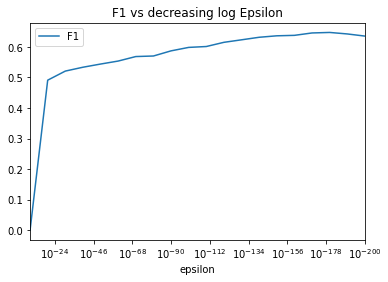

In [7]:
import matplotlib.pyplot as plt

EpsF1df.plot.line("epsilon","F1")
plt.xscale('log')
plt.xlim(1e-10, 1e-200)
plt.title("F1 vs decreasing log Epsilon")
plt.show()

In [8]:
eps = EpsF1df.loc[EpsF1df['F1'].idxmax()]['epsilon']

print("epsilon ", eps)
print("_"*50)
mn_pred = (x<=eps)
mn_pred = list(map(lambda x : 0 if x==True else 1, mn_pred))

epsilon  1e-180
__________________________________________________


#### auto encoder

In [9]:
# from keras.models import Model, load_model
# from keras.layers import Input, Dense
# from keras.callbacks import ModelCheckpoint, TensorBoard
# from keras import regularizers

In [10]:
# X_train = df.drop('ID',axis=1)

In [11]:
# input_dim = X_train.shape[1]
# encoding_dim = 14

In [12]:
# # Keras Auto Encoder model

# input_layer = Input(shape=(input_dim, ))

# encoder = Dense(encoding_dim, activation="tanh", 
#                 activity_regularizer=regularizers.l1(10e-5))(input_layer)
# encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

# decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
# decoder = Dense(input_dim, activation='relu')(decoder)

# autoencoder = Model(inputs=input_layer, outputs=decoder)

# autoencoder.summary()

In [13]:
# nb_epoch = 10
# batch_size = 32

# autoencoder.compile(optimizer='adam', 
#                     loss='mean_squared_error', 
#                     metrics=['accuracy'])

# checkpointer = ModelCheckpoint(filepath="model.h5",
#                                verbose=0,
#                                save_best_only=True)
# tensorboard = TensorBoard(log_dir='./logs',
#                           histogram_freq=0,
#                           write_graph=True,
#                           write_images=True)

# history = autoencoder.fit(X_train, X_train,
#                     epochs=nb_epoch,
#                     batch_size=batch_size,
#                     shuffle=True,
#                     verbose=1,
#                     callbacks=[checkpointer, tensorboard]).history

## Local Outlier Factor (LOF)

In [14]:
val_normal, val_fraud = val_df['Class'].value_counts()
val_contamination = val_fraud / val_normal

In [15]:
# fit the model for outlier detection (default)
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=50, contamination = val_contamination)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(val_df.drop('Class',axis=1))
y_pred = list(map(lambda x : 1 if x==-1 else 0, y_pred))
n_errors = (y_pred != val_df['Class']).sum()
X_scores = clf.negative_outlier_factor_
n_errors

23

In [16]:
lof_pred = y_pred.copy()

In [17]:
# F1 Score
f1_score(val_df['Class'],lof_pred, average='macro')

0.8112731693633506

## Isolation Forest

In [18]:
from sklearn.ensemble import IsolationForest

# isofo = IsolationForest(n_estimators = 1050, max_features = 1.0, max_samples=1.0, 
#                          bootstrap=False, random_state=22,
#                         contamination = val_contamination)

isofo = IsolationForest(n_estimators = 125, max_features = 1.0, max_samples=len(val_df.drop('Class',axis=1)), 
                         bootstrap=False, random_state=22,
                        contamination = val_contamination,
                        verbose=0)

y_pred = isofo.fit_predict(val_df.drop('Class',axis=1))
y_pred = list(map(lambda x : 1 if x==-1 else 0, y_pred))
n_errors = (y_pred != val_df['Class']).sum()
print(n_errors)

c:\Users\kimji\.conda\envs\tf25_py37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


39


In [19]:
if_pred = y_pred.copy()

In [20]:
# F1 Score
f1_score(val_df['Class'],if_pred, average='macro')

0.6799849393552464

## One Class SVM

In [21]:
from sklearn.svm import OneClassSVM


OneSVM = OneClassSVM(nu = val_contamination)

y_pred = OneSVM.fit_predict(val_df.drop('Class',axis=1))
y_pred = list(map(lambda x : 1 if x==-1 else 0, y_pred))
n_errors = (y_pred != val_df['Class']).sum()
print(n_errors)

295


In [22]:
oc_pred = y_pred.copy()

In [23]:
# F1 Score
f1_score(val_df['Class'],oc_pred, average='macro')

0.5350117779840998

## EllipticEnvelope

In [24]:
from sklearn.covariance import EllipticEnvelope

cov = EllipticEnvelope(support_fraction = 1,assume_centered=False, contamination = val_contamination,random_state=777)
ee_pred = cov.fit_predict(val_df)
ee_pred = list(map(lambda x : 0 if x==1 else 1, ee_pred))

In [31]:
ls = []

for i,j,k,l,m in zip(mn_pred, lof_pred, if_pred, oc_pred, ee_pred):
    if i+j+k+l+m > 2:
        ls.append(1)
    else:
        ls.append(0)

In [32]:
f1_score(val_df['Class'],ls, average='macro')

0.8440952268653764

# test

## multivariate_normal

In [ ]:
from scipy.stats import multivariate_normal
import numpy as np

p = multivariate_normal(mean=np.mean(test_df.drop('ID',axis=1),axis=0), cov=np.cov(test_df.drop('ID',axis=1).T))

In [ ]:
eps = 1e-180
x = p.pdf(test_df.drop('ID',axis=1))
mn_pred = (x<=eps)
mn_pred = list(map(lambda x : 0 if x==False else 1, mn_pred))

## Local Outlier Factor (LOF)

In [ ]:
val_normal, val_fraud = val_df['Class'].value_counts()
val_contamination = val_fraud / val_normal

In [ ]:
# fit the model for outlier detection (default)
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=50, contamination = val_contamination)
y_pred = clf.fit_predict(test_df.drop('ID',axis=1))
y_pred = list(map(lambda x : 1 if x==-1 else 0, y_pred))
lof_pred = y_pred.copy()

## Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

isofo = IsolationForest(n_estimators = 125, max_features = 1.0, max_samples=len(test_df.drop('ID',axis=1)), 
                         bootstrap=False, random_state=22,
                        contamination = val_contamination,
                        verbose=0)

y_pred = isofo.fit_predict(test_df.drop('ID',axis=1))
y_pred = list(map(lambda x : 1 if x==-1 else 0, y_pred))
if_pred = y_pred.copy()

## One Class SVM

In [ ]:
from sklearn.svm import OneClassSVM


OneSVM = OneClassSVM(nu = val_contamination)

y_pred = OneSVM.fit_predict(test_df.drop('ID',axis=1))
y_pred = list(map(lambda x : 1 if x==-1 else 0, y_pred))
oc_pred = y_pred.copy()

## EllipticEnvelope

In [ ]:
from sklearn.covariance import EllipticEnvelope

cov = EllipticEnvelope(support_fraction = 1,assume_centered=False, contamination = val_contamination,random_state=777)
ee_pred = cov.fit_predict(test_df.drop('ID',axis=1))
ee_pred = list(map(lambda x : 0 if x==1 else 1, ee_pred))

In [ ]:
mn_pred
lof_pred
if_pred
oc_pred
ee_pred

In [ ]:
ls = []

for i,j,k,l,m in zip(mn_pred, lof_pred, if_pred, oc_pred, ee_pred):
    if i+j+k+l+m > 2:
        ls.append(1)
    else:
        ls.append(0)

In [ ]:
pd.DataFrame(ls).value_counts()

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['Class'] = ls
submit.to_csv('./submit_merge.csv', index=False)